In [1]:
from Tools_Libraries import *
from IonModel_Libraries import *
from LimitSetting_Libraries import *
from WIMP_Libraries import *
from DP_Libraries import *
from Ultimate_Libraries import *
from Backgrounds_Libraries import *

In [ ]:
Exp = Experiment()
Exp.Voltage = 10
Exp.SigmaeV = 200
Exp.Exposure = 1
Exp.Fano = 0.2
Exp.TriggerNsigma = 3

Energyscale = "eV"
EminAnalysis = 1 
EmaxAnalysis = 100000
nptx = 1000 # precision of the analysis, the higher the better, but slower
OR = Oracle(EminAnalysis,EmaxAnalysis,nptx)

def CalculateLimit(Exp = Experiment(),OR = Oracle(), Energyscale="eV", signaltype="DP",mass=10,massindex=False,bash=False):
    start = time.time()ç_è
    assert signaltype in ["DP","WIMP"]
    assert Energyscale in ["eV","eVee"]
    
    # get analysis range to determine the  energy range for the plot
    Emin, Emax = OR.GetAnalysisRange()
    nptx = OR.GetAnalysisNptx()
    logx = True
    x = np.linspace(Emin,Emax,nptx) if logx==False else np.logspace(np.log10(Emin),np.log10(Emax),nptx)
    
    # now that we have extracted the energy range for the plot, we can set the analysis threshold at NTriggerSigma * Sigma
    Emin = Exp.TriggerNsigma*Exp.SigmaeV if (Energyscale=="eV") else Exp.TriggerNsigma*Exp.SigmaeVee
    OR.SetAnalysisRange((Emin,Emax))

    # define background components
    Compton = Spectrum("ER",Exp)
    Compton.SetFunc(lambda x: np.ones_like(x)*1e-2,0,1e9)
    ComptonEnergySpectrum = Compton.GetEphononSmearedFunc(Energyscale)
    
    HeatOnly = Spectrum("HO",Exp)
    HeatOnly.SetFunc(fonctionHOdivided1000,0,1e9)
    HeatOnlyEnergySpectrum = HeatOnly.GetEphononSmearedFunc(Energyscale)
    
    EDWBeta = Spectrum("BETA",Exp)
    EDWBeta.SetFunc(lambda x: EDWfuncBETA(x,scale = "eV",norm=1),0,1e9)
    EDWBetaEnergySpectrum =  EDWBeta.GetEphononSmearedFunc(Energyscale)
    
    EDWLead = Spectrum("LEAD",Exp)
    EDWLead.SetFunc(lambda x: EDWfuncLEAD(x,scale = "eV",norm=1),0,1e9)
    EDWLeadEnergySpectrum =  EDWLead.GetEphononSmearedFunc(Energyscale)
    
    EDWHO = Spectrum("HO",Exp)
    EDWHO.SetFunc(lambda x: EDWfuncHEATONLY(x,scale = "eV",norm=1),0,1e9)
    EDWHOEnergySpectrum =  EDWHO.GetEphononSmearedFunc(Energyscale)
    
    EDWNeutron = Spectrum("NEUTRON",Exp)
    EDWNeutron.SetFunc(lambda x: EDWfuncNEUTRON(x,scale = "eV",norm=1),0,1e9)
    EDWNeutronEnergySpectrum =  EDWNeutron.GetEphononSmearedFunc(Energyscale)
    
    EDWCompton = Spectrum("COMPTON",Exp)
    EDWCompton.SetFunc(lambda x: EDWfuncCOMPTON(x,scale = "eV",norm=1),0,1e9)
    EDWComptonEnergySpectrum =  EDWCompton.GetEphononSmearedFunc(Energyscale)
       
    # define signal components
    if signaltype=="DP":
        D = DP_Parameters()
        if massindex==False:
            D.SetDPmass(mass) # eV/c2
        else:
            D.SetDPmassindex(mass) # eV/c2
        actualmass = D.GetDPmass()
        D.SetKappa(1e-14)
        DarkPhotons = Spectrum(D,Exp)
        DarkPhotonsEnergySpectrum = DarkPhotons.GetEphononSmearedLine(Energyscale)
        
    elif signaltype == "WIMP":
        W = WIMP_Parameters()
        W.WIMPmass = mass
        actualmass = W.WIMPmass
        W.CrossSection = 1e-4
        Wimps = Spectrum(W,Exp)
        WimpsEnergySpectrum = Wimps.GetEphononSmearedFunc(Energyscale)
    else:
        print("ERROR")
    
    # Add backgrounds and signal to the analysis class : Oracle 
    OR.AddBackground(ComptonEnergySpectrum,"Compton Bkg")
    OR.AddBackground(HeatOnlyEnergySpectrum,"HO Bkg")
    OR.AddBackground(EDWBetaEnergySpectrum,"EDW BETA Bkg")
    OR.AddBackground(EDWLeadEnergySpectrum,"EDW LEAD Bkg")
    OR.AddBackground(EDWHOEnergySpectrum,"EDW HO Bkg")
    OR.AddBackground(EDWNeutronEnergySpectrum,"EDW NEUTORN Bkg")
    OR.AddBackground(EDWComptonEnergySpectrum,"EDW COMPTON Bkg")
    
  
    if signaltype=="DP":
        OR.AddSignal(DarkPhotonsEnergySpectrum)
        OR.SetVariableOfInterest(D.GetKappa()**2)
    elif signaltype == "WIMP":
        OR.AddSignal(WimpsEnergySpectrum)
        OR.SetVariableOfInterest(W.CrossSection)
    
    fb = OR.GetTotalBackground()
    fs = OR.GetSignal()

    ROIlist = OR.CalculateROI_Bounds(fs,fb)

    if signaltype=="DP":
        kappaexcluded = np.sqrt(OR.CalculateExcludedVariableOfInterest())
        Dexcluded = copy.copy(D)
        Dexcluded.SetKappa(kappaexcluded)
        DarkPhotonsexcluded = Spectrum(Dexcluded,Exp)
   
    elif signaltype == "WIMP":
        sigmaexcluded = OR.CalculateExcludedVariableOfInterest()
        Wexcluded = copy.copy(W)
        Wexcluded.CrossSection = sigmaexcluded
        Wimpsexcluded = Spectrum(Wexcluded,Exp)
               
    muexcluded = OR.GetExcludedMu()
      
    end = time.time()
    print(f"{end-start:.2f} seconds to calculate the limit" )
    if (bash == False):
        fig, ax = plt.subplots(figsize=(7,5))
        
        for name in OR.GetBackgroundNames():
            tf1 = OR.GetBackground(name)
            plt.plot(x,tf1(x),label=name,lw=4)
            
        yb = fb(x)
        ax.plot(x,yb,color="black",ls='--',label="Total Bkg",lw=4)       
        ax.set_ylim(bottom=1e-5,top=1e6)
        ax.set_yscale('log')
        
        if logx:
            ax.set_xscale('log')
            
        if signaltype=="DP":
            title1 = "DP signal excluded, m={:.2f} eV/c$^2$".format(actualmass)
            title2 = "$\kappa={:.2e}$, $\mu={:.2f}$".format(kappaexcluded,muexcluded)
            fsexcluded = DarkPhotonsexcluded.GetEphononSmearedLine(Energyscale)
        elif signaltype == "WIMP":
            title1 = "WIMP signal excluded, m={:.2f} GeV/c$^2$".format(actualmass)
            title2 = "$\sigma$={:.2e} pb, $\mu={:.2f}$".format(sigmaexcluded,muexcluded) 
            fsexcluded = Wimpsexcluded.GetEphononSmearedFunc(Energyscale)
            
        yexcl = fsexcluded(x)
        ax.plot(x,yexcl,label=title1,lw=4,color='red')
        ax.fill_between(x,yb,yexcl, alpha=0.5,where=(yexcl>yb),color='red')
        ax.plot([], [],' ',label=title2)

        if(Energyscale=="eVee"):
            ftransform = lambda x : x/Exp.Epsilon
            finv = lambda x : x*Exp.Epsilon
            secax = ax.secondary_xaxis('top', functions=(ftransform,finv))
        else:
            ftransform = lambda x : x/(1+Exp.Voltage/Exp.Epsilon)/Exp.Epsilon
            finv = lambda x : x*(1+Exp.Voltage/Exp.Epsilon)/Exp.Epsilon
            secax = ax.secondary_xaxis('top', functions=(ftransform,finv),color="royalblue")
         

        secax.set_xlabel('Electron number of e$^-$/ h$^+$ for electron recoils')
        ax.grid(which='both')
        ax.set_xlabel("Energy [{}]".format(Energyscale))
        ax.set_ylabel("Events / {} kg.days / {}".format(Exp.Exposure,Energyscale))
        ax.legend(loc='upper right')
        
        OR.PlotROIs(color="red",ls="--",prop=1)
        OR.PlotThreshold()
        
        end2 = time.time()
        print(f"{end2-end:.2f} additional seconds to do the plot" )   
    if signaltype=="DP":
        return actualmass, kappaexcluded, muexcluded 
    elif signaltype == "WIMP":
        return actualmass, sigmaexcluded, muexcluded 
    
_ = CalculateLimit(Exp = Exp,OR = OR,Energyscale = Energyscale , signaltype="WIMP", mass=10,massindex=False)        



Existing PoissonDataFile with 1000 precalculated values is used


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: divide by zero encountered in log10
/opt/conda/lib/python3.7/site-packages/numpy/core/function_base.py:151: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.7/site-packages/numpy/core/function_base.py:161: RuntimeWarning: invalid value encountered in add
  y += start


final ROI list consists of 1 ROI(s)
[623.22,1000.00] eV
1.39 seconds to calculate the limit


ValueError: Number of samples, -9223372036854775808, must be non-negative.

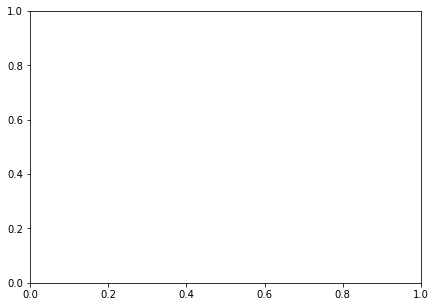

In [4]:
Energyscale = "eV"
EminAnalysis = 0 
EmaxAnalysis = 1000
nptx = 1000 # precision of the analysis, the higher the better, but slower
OR = Oracle(EminAnalysis,EmaxAnalysis,nptx)
_ = CalculateLimit(Exp = Exp,OR = OR,Energyscale = Energyscale , signaltype="WIMP", mass=10,massindex=False) 